<a href="https://colab.research.google.com/github/Rocco12k/Data-Mining/blob/main/Data_Mining_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First we need to import the appropriate libraries so that it could help us read the data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql.types import FloatType, IntegerType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

Now we load out Hulu data as a csv file which allows us to work with the content

In [ ]:
Hulu_df = pd.read_csv('data.csv')
Hulu_df

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2392507.0,NaN
1,Unforgiven,movie,"Drama, Western",1992.0,tt0105695,8.2,456488.0,NaN
2,2001: A Space Odyssey,movie,"Adventure, Sci-Fi",1968.0,tt0062622,8.3,757071.0,NaN
3,12 Monkeys,movie,"Mystery, Sci-Fi, Thriller",1995.0,tt0114746,8.0,665833.0,NaN
4,Billy Elliot,movie,"Drama, Music",2000.0,tt0249462,7.7,148430.0,NaN
...,...,...,...,...,...,...,...,...
10792,NaN,tv,"Animation, Crime, Mystery",1996.0,NaN,NaN,NaN,NaN
10793,Murder Has Two Faces,tv,"Crime, Documentary",2025.0,tt36734143,6.4,47.0,NaN
10794,NaN,tv,"Animation, Mystery",2009.0,NaN,NaN,NaN,NaN
10795,NaN,tv,NaN,2014.0,NaN,NaN,NaN,NaN


This is bascially just to check quickly the data types we are working with.

In [ ]:
Hulu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10797 entries, 0 to 10796
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               10074 non-null  object 
 1   type                10797 non-null  object 
 2   genres              10409 non-null  object 
 3   releaseYear         10753 non-null  float64
 4   imdbId              9607 non-null   object 
 5   imdbAverageRating   9319 non-null   float64
 6   imdbNumVotes        9319 non-null   float64
 7   availableCountries  39 non-null     object 
dtypes: float64(3), object(5)
memory usage: 674.9+ KB


After viewing the data i came to a conclusion that i could drop usless columns which is the ('available countries') since most of its data is null. So we could keep our data neat.

In [ ]:
columns_to_drop = ['availableCountries']
Hulu_df = Hulu_df.drop(columns=[col for col in columns_to_drop if col in Hulu_df.columns])
Hulu_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10797 entries, 0 to 10796
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              10074 non-null  object 
 1   type               10797 non-null  object 
 2   genres             10409 non-null  object 
 3   releaseYear        10753 non-null  float64
 4   imdbId             9607 non-null   object 
 5   imdbAverageRating  9319 non-null   float64
 6   imdbNumVotes       9319 non-null   float64
dtypes: float64(3), object(4)
memory usage: 590.6+ KB


I saw that we were missing some values, so i wanted to fill them with 0 early so it does not ruin or break my analysis later

In [ ]:
Hulu_df['imdbAverageRating'].fillna(0, inplace=True)
Hulu_df['imdbNumVotes'].fillna(0, inplace=True)

Hulu_df['releaseYear'].fillna(0, inplace=True)
Hulu_df['releaseYear'] = Hulu_df['releaseYear'].astype(int)
Hulu_df['imdbAverageRating'] = Hulu_df['imdbAverageRating'].astype(float)
Hulu_df['imdbNumVotes'] = Hulu_df['imdbNumVotes'].astype(int)

In [ ]:
Hulu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10797 entries, 0 to 10796
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              10074 non-null  object 
 1   type               10797 non-null  object 
 2   genres             10409 non-null  object 
 3   releaseYear        10797 non-null  int64  
 4   imdbId             9607 non-null   object 
 5   imdbAverageRating  10797 non-null  float64
 6   imdbNumVotes       10797 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 590.6+ KB


I wanted to make pie chart to basically show me the most popular genres in my Hulu dataset.

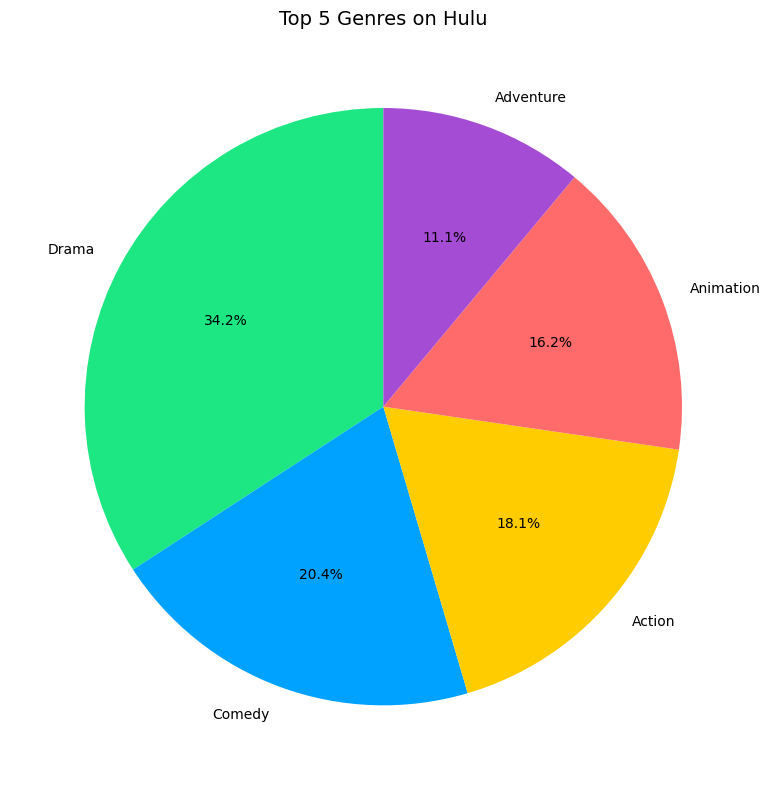

In [ ]:
import matplotlib.pyplot as plt

#To count the genres
genres = Hulu_df['genres'].str.split(', ').explode()
top_genres = genres.value_counts().nlargest(5)

#And finally to create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_genres,
        labels=top_genres.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#1ce783', '#00a2ff', '#ffcc00', '#ff6b6b', '#a44cd3'])

plt.title('Top 5 Genres on Hulu', fontsize=14)
plt.tight_layout()
plt.show()

After the pie chart, i wanted a bar graph showing me the top rated title on Hulu. To help with understanding trends and making recommendations

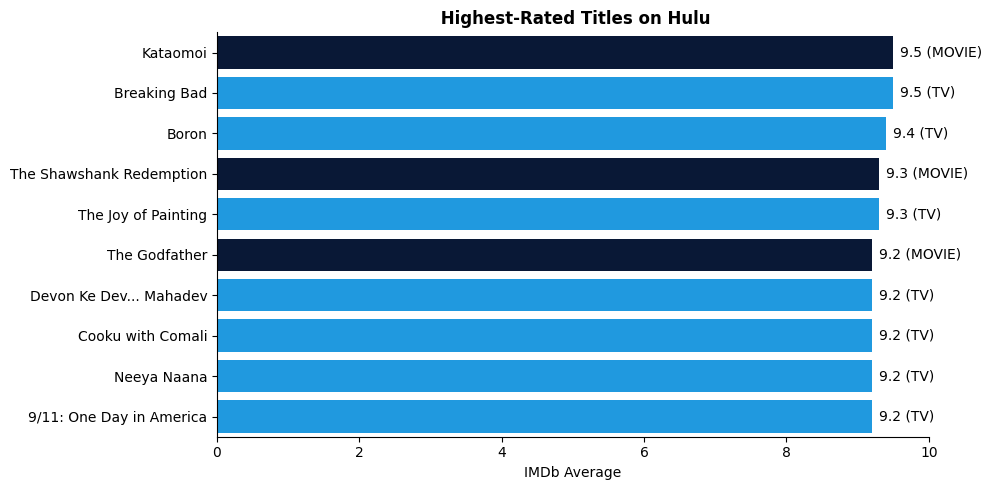

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Fetches me the top 5 titles by IMDb rating
top_titles = Hulu_df.dropna(subset=['imdbAverageRating']).nlargest(10, 'imdbAverageRating')

#This is the bar plot but horizontally
plt.figure(figsize=(10, 5))
bars = sns.barplot(data=top_titles,
                   x='imdbAverageRating',
                   y='title',
                   palette=['#01153E' if x == 'movie' else '#00a2ff' for x in top_titles['type']],
                   dodge=False)

#Adding basic labels
for i, (rating, content_type) in enumerate(zip(top_titles['imdbAverageRating'], top_titles['type'])):
    bars.text(rating + 0.1, i,
             f'{rating:.1f} ({content_type.upper()})',
             va='center')

plt.title(' Highest-Rated Titles on Hulu', fontweight='bold')
plt.xlabel('IMDb Average')
plt.ylabel('')
plt.xlim(0, 10)
sns.despine()
plt.tight_layout()
plt.show()

Next i created a line graph showing me how wmany movies or series were released each year. To show how our library grew over time, also helps in spotting trends.

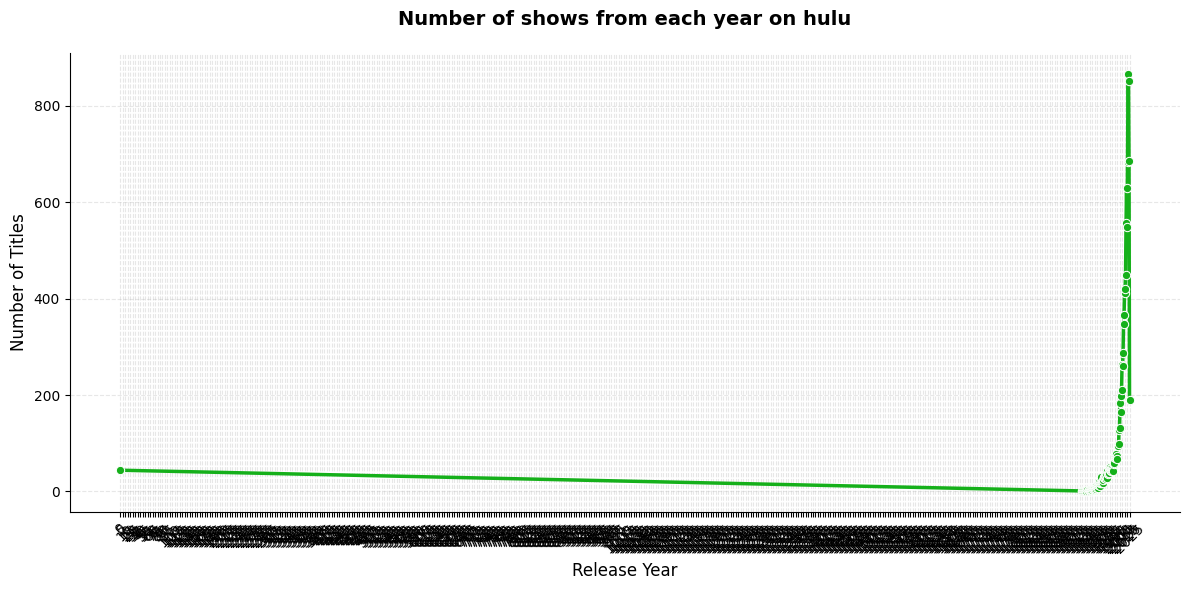

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#In order to prepare the data
titles_per_year = Hulu_df['releaseYear'].value_counts().sort_index()

#Creating the plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=titles_per_year.index,
             y=titles_per_year.values,
             color='#15B01A',  # Hulu green
             linewidth=2.5,
             marker='o')

#Formatting it
plt.title('Number of shows from each year on hulu',
          fontsize=14, pad=20, fontweight='bold')
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of Titles', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

#Simply ajusting the x-axis
start_year = int(titles_per_year.index.min())
end_year = int(titles_per_year.index.max())
plt.xticks(range(start_year, end_year+1, 5), rotation=45)

sns.despine()
plt.tight_layout()
plt.show()

This is the content-based filtering, wherre i used  a TF-IDF to basically to convert genres into numerical data. The code get_recommendations speaks for itslef, suggests the user similar titles. if they like one, shows them similar ones.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


movies = Hulu_df.dropna(subset=['title', 'genres']).copy()
movies['genres'] = movies['genres'].str.replace(', ', ' ')

#Create TF-IDF matrix of genres
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

#Calculate the cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

#Building the recommendation function
def get_recommendations(title, n=5):
    idx = movies[movies['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]  # Skip self
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]

#just an example
print("Recommendations similar to '12 Monkeys':")
print(get_recommendations('12 Monkeys'))

Recommendations similar to '12 Monkeys':
477                             Sphere
618                            Knowing
1758                     Enter Nowhere
3057    The Top Secret: Murder in Mind
3913                              2067
Name: title, dtype: object


Simulate 500 users to give out random ratings so after train a collaborative filtering model. just to give out a 'recommended for you'

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
import numpy as np

#Initiate the Spark session
spark = SparkSession.builder.master("local[*]").appName("HuluALS").getOrCreate()

#For collaborative filtering, we need userId, movieId (or title), and rating

num_users = 500
num_movies = Hulu_df.shape[0]

#User ratings
np.random.seed(42)
user_ids = np.random.randint(0, num_users, num_movies)
ratings = np.random.uniform(1, 5, num_movies).round(1)

#Add to the DataFrame
Hulu_df['userId'] = user_ids
Hulu_df['rating'] = ratings

Hulu_df['movieId'] = pd.factorize(Hulu_df['title'])[0]

#Create Spark DataFrame
spark_df = spark.createDataFrame(Hulu_df[['userId', 'movieId', 'rating']])
spark_df = spark_df.withColumn("userId", col("userId").cast(IntegerType())) \
                   .withColumn("movieId", col("movieId").cast(IntegerType())) \
                   .withColumn("rating", col("rating").cast(FloatType()))

spark_df.show(5)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|   102|      0|   1.4|
|   435|      1|   1.6|
|   348|      2|   4.5|
|   270|      3|   3.1|
|   106|      4|   2.9|
+------+-------+------+
only showing top 5 rows



In [ ]:
#Split into train and test sets
(training, test) = spark_df.randomSplit([0.8, 0.2], seed=42)

Just basically test the collaborative filtering model using the MSE. The lowerthe MSE the more reliable

In [ ]:
from pyspark.ml.recommendation import ALS

als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True
)
model = als.fit(training)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = model.transform(test)
evaluator = RegressionEvaluator(
    metricName="mse",
    labelCol="rating",
    predictionCol="prediction"
)
als_mse = evaluator.evaluate(predictions)
print(f"Collaborative Filtering (ALS) MSE: {als_mse:.4f}")

Collaborative Filtering (ALS) MSE: 3.2439


I wanted to compare our collaborative system whilst just using IMDb ratings. To tell me which system performs better.

In [ ]:
#For content-based im gojng to be using imdbAverageRating as the "predicted" rating
test_pd = test.toPandas()
test_pd = test_pd.merge(Hulu_df[['movieId', 'imdbAverageRating']], on='movieId', how='left')
test_pd['imdbAverageRating'] = test_pd['imdbAverageRating'].fillna(test_pd['imdbAverageRating'].mean())

#Calculating the MSE
from sklearn.metrics import mean_squared_error
cbf_mse = mean_squared_error(test_pd['rating'], test_pd['imdbAverageRating'])
print(f"Content-Based Filtering MSE: {cbf_mse:.4f}")

Content-Based Filtering MSE: 10.8320


Just to visulaize the comparison helps me judge which system recommendation is better or in this sense more accurate.

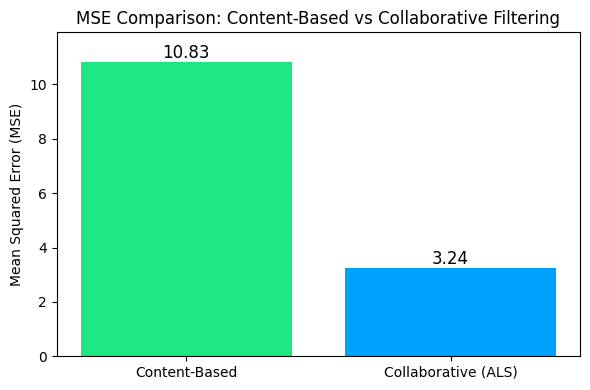

In [ ]:
import matplotlib.pyplot as plt

mse_scores = [cbf_mse, als_mse]
methods = ['Content-Based', 'Collaborative (ALS)']

plt.figure(figsize=(6, 4))
bars = plt.bar(methods, mse_scores, color=['#1ce783', '#00a2ff'])
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE Comparison: Content-Based vs Collaborative Filtering')
for bar, score in zip(bars, mse_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{score:.2f}", ha='center', va='bottom', fontsize=12)
plt.ylim(0, max(mse_scores)*1.1)
plt.tight_layout()
plt.show()


conclusion of the work. basic summary

In [ ]:
import pandas as pd

results = pd.DataFrame({
    'Method': ['Content-Based', 'Collaborative (ALS)'],
    'MSE': [cbf_mse, als_mse]
})
print(results)

                Method        MSE
0        Content-Based  10.831984
1  Collaborative (ALS)   3.243861
